# Make starless images

This is meant to be run on data that have been through BrA_Separation, I think

In [1]:
from astropy.io import fits
import numpy as np

In [2]:
import sys
if '' in sys.path:
    sys.path.remove('')

In [3]:
import regions
assert hasattr(regions, 'Regions')

In [4]:
%matplotlib inline

In [5]:
basepath = '/orange/adamginsburg/jwst/brick/'
from astropy.wcs import WCS

In [6]:
ww = WCS(fits.getheader(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits'))
data = np.array(fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits')).copy()

Set OBSGEO-B to   -20.633624 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526085287.516 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [7]:
data.shape

(2296, 2901)

In [8]:
import pylab as pl
from astropy.visualization import simple_norm
def imshow_norm(data, ax=None, **kwargs):
    if ax is None:
        ax = pl.gca()
    return ax.imshow(data, norm=simple_norm(data, **kwargs), **kwargs)

In [9]:
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['image.origin'] = 'lower'

# Destar 1: basic DAOStarFinder

In [10]:
import photutils
from photutils.detection import DAOStarFinder, IRAFStarFinder

In [11]:
# June 21, 2023: threshold had to be increased because stars were overkilled around the edges; don't know what changed.
# June 26: back to threshold=30
stars_bra = DAOStarFinder(threshold=30, fwhm=1.9, peakmax=1e4)(data)
len(stars_bra)

1928

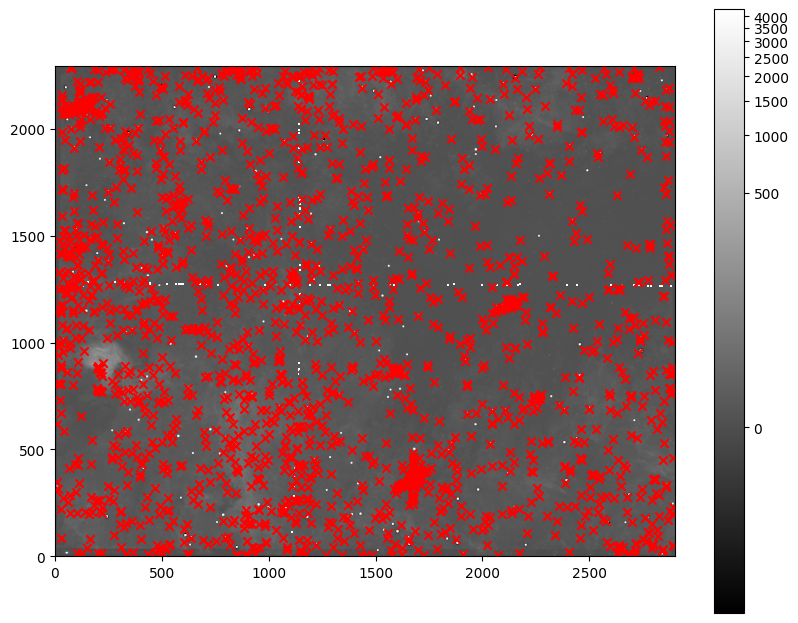

In [12]:
pl.imshow(data, norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.colorbar();
pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

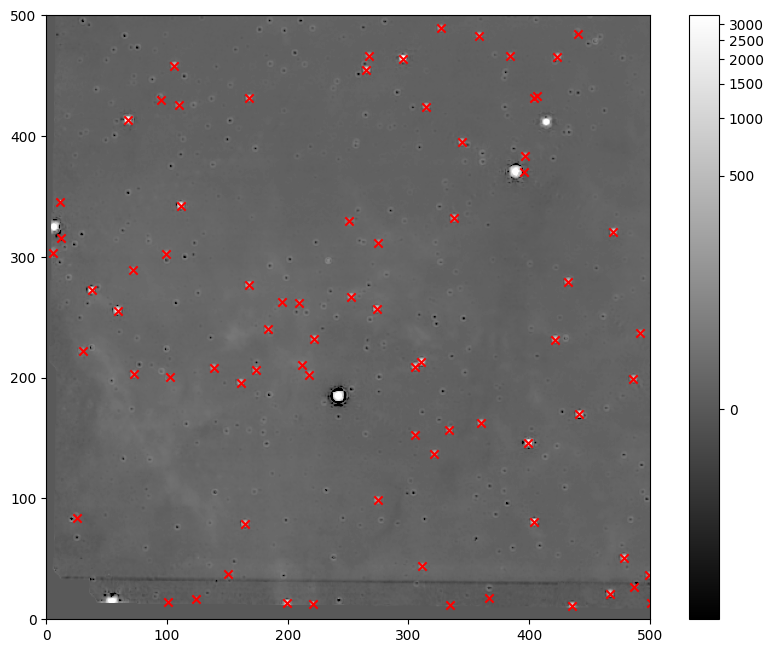

In [13]:
pl.imshow(data[:500,:500], norm=simple_norm(data[:500,:500], min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.colorbar();
pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')
pl.axis([0,500,0,500]);

In [14]:
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel

In [15]:
def kill_star(cutout, radius, kernelwidth=1, nanneg=False, zeroneg=True):
    #print(cutout.size)
    cutoutcopy = cutout.copy()
    #print(cutoutcopy.size)
    yy, xx = np.indices(cutout.shape)
    #print("yy")
    rr2 = (xx - cutout.shape[1]/2)**2 + (yy - cutout.shape[0]/2)**2
    #print("rr2")
    msk = rr2 < radius**2
    # ignore negatives
    if nanneg:
        msk[cutoutcopy < 0] = np.nan
    #print('msksum: ',msk.sum())
    cutoutcopy[msk] = np.nan
    sm = convolve(cutoutcopy, Gaussian2DKernel(kernelwidth))
    sm[sm < 0] = 0
    cutoutcopy[msk] = sm[msk]
    return cutoutcopy

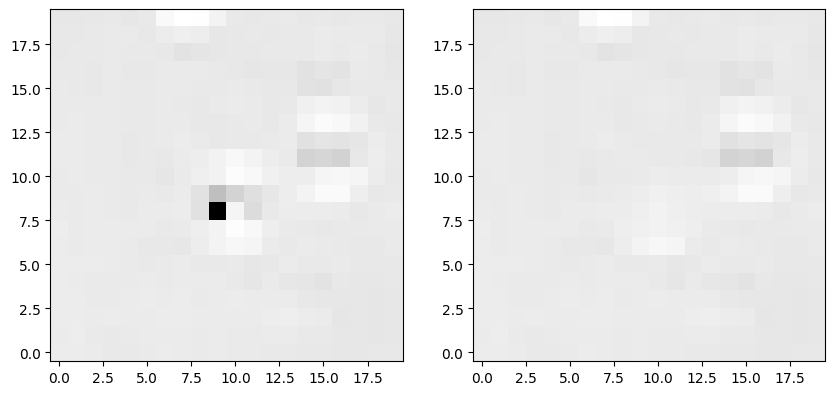

In [16]:
row = stars_bra[35]
sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
co = data[sy-10:sy+10, sx-10:sx+10]
pl.subplot(1,2,1).imshow(co, norm=simple_norm(co, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(kill_star(co, 3.5), norm=simple_norm(co, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')

In [17]:
from tqdm.notebook import tqdm

In [18]:
#datacopy = data.copy()

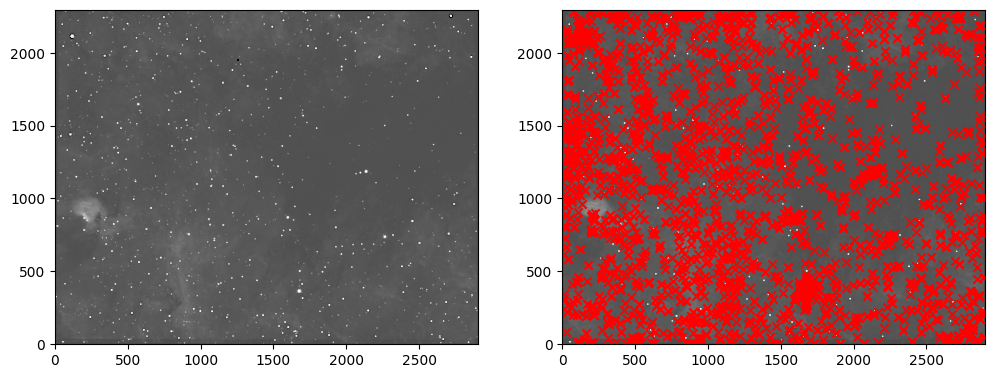

In [19]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray');
pl.subplot(1,2,2)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray');
pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [20]:
print(np.isnan(data).sum())
for sy, sx in tqdm(zip(*np.where(np.isnan(data)))):
    if sx > 5 and sy > 5 and sy < data.shape[0] - 5 and sx < data.shape[1] - 5:
        co = data[sy-5:sy+5, sx-5:sx+5]
        #print(np.isnan(co)).sum()
        data[sy-5:sy+5, sx-5:sx+5] = kill_star(co, 1)
        #print(np.isnan(data[sy-5:sy+5, sx-5:sx+5]).sum())
print(np.isnan(data).sum())
assert not np.isnan(data[1054,645])

80


0it [00:00, ?it/s]

1


In [21]:
for row in tqdm(stars_bra):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/1928 [00:00<?, ?it/s]

In [22]:
np.isnan(data).sum()

1

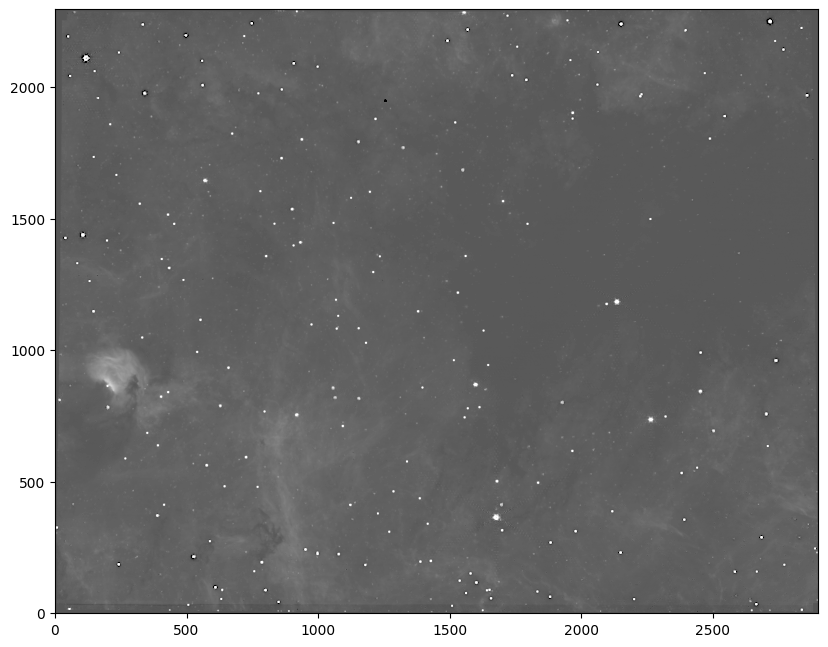

In [23]:
pl.imshow((data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [24]:
data[1054,645]

8.786317096123401

In [25]:
pl.imshow((data[1050:1060,640:650]), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [26]:
header = fits.getheader(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred.fits', overwrite=True)

# Destar 2: higher threshold, lower peakmax, based on F410

In [27]:
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
stars_410 = DAOStarFinder(threshold=150, fwhm=2.302, peakmax=1000)(fh_410['SCI'].data)
len(stars_410)

6540

In [28]:
for row in tqdm(stars_410):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 5.5, 1.5)

  0%|          | 0/6540 [00:00<?, ?it/s]

In [29]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [30]:
header = fits.getheader(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred2.fits', overwrite=True)

# Destar 3: higher threshold, higher peakmax, based on f405.  Bigger cutout.

In [31]:
fh_405 = fits.open(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits')
stars_bra_br = DAOStarFinder(threshold=2000, fwhm=2.302, peakmax=3e4)(fh_405['SCI'].data)
len(stars_bra_br)

682

In [32]:
for row in tqdm(stars_bra_br):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 7.5, 2)

  0%|          | 0/682 [00:00<?, ?it/s]

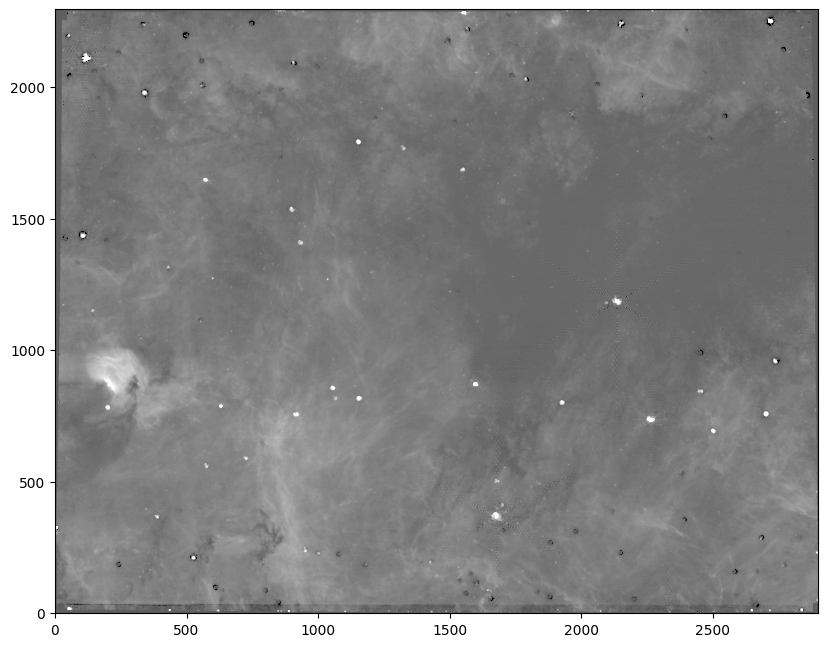

In [33]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [34]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred3.fits', overwrite=True)

In [35]:
data = fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred3.fits')

# Destar 4: segmentationmap

In [36]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(data, 100, npixels=5)

In [37]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segment_map)
cattbl = cat.to_table()

In [38]:
# pixel coordinate of bright extended emission
xk,yk = 208,782

In [39]:
for row in tqdm(cat):
    if row.area.value > 1000: 
        print(f"Skipping {row}, {row.centroid}")
        continue
    if xk < row.bbox.ixmin or xk > row.bbox.ixmax or yk < row.bbox.iymin or yk > row.bbox.ixmax:
        sx,sy = map(int, (row.centroid))
        dx = 15 if row.area.value < 75 else 25
        rad_excise = 7.5 if row.area.value < 75 else 12.5
        rad_kernel = 2 if row.area.value < 75 else 4
        if sx > dx and sy > dx and sy < data.shape[0] - dx and sx < data.shape[1] - dx:
            co = data[sy-dx:sy+dx, sx-dx:sx+dx]
            data[sy-dx:sy+dx, sx-dx:sx+dx] = kill_star(co, rad_excise, rad_kernel)
    else:
        print(f"Skipped {row} -> {row.centroid}")

  0%|          | 0/79 [00:00<?, ?it/s]

Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [44], [220.57186677 903.77598805]


In [40]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

In [41]:
import sys
if '' in sys.path:
    sys.path.remove('')
import regions
regs = regions.Regions.read(f'{basepath}/regions/manual_destar_left_405.reg')

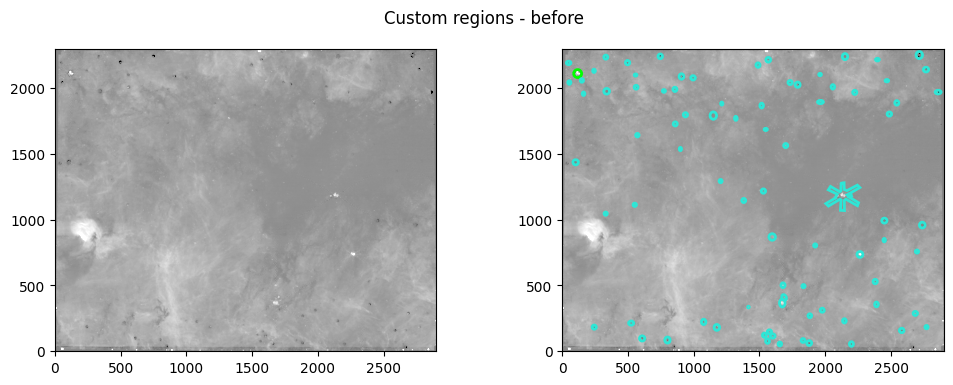

In [42]:
pl.figure(figsize=(12,4))
pl.suptitle("Custom regions - before")
pl.subplot(1,2,1)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
for reg in regs:
    preg = reg.to_pixel(ww)
    preg.plot()

In [43]:
for reg in tqdm(regs):
    preg = reg.to_pixel(ww)
    mask = preg.to_mask()
    bbox = mask.bbox
    dx = 10
    bbox.ixmin -= dx
    bbox.iymin -= dx
    bbox.ixmax += dx
    bbox.iymax += dx
    co = data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax].copy()
    #print(bbox, co.shape, data.shape, mask.data.shape)
    co[dx:-dx, dx:-dx][mask.data.astype('bool')] = np.nan
    msk = np.isnan(co)
    rad = ((np.max(mask.shape)/2) ** 2 + dx**2)**0.5
    smrad = np.min([np.max([10, rad/2]), 50])
    sm = convolve(co, Gaussian2DKernel(smrad))    
    #sm[sm < 0] = 0
    co[msk] = sm[msk]
    data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax] = co

  0%|          | 0/83 [00:00<?, ?it/s]

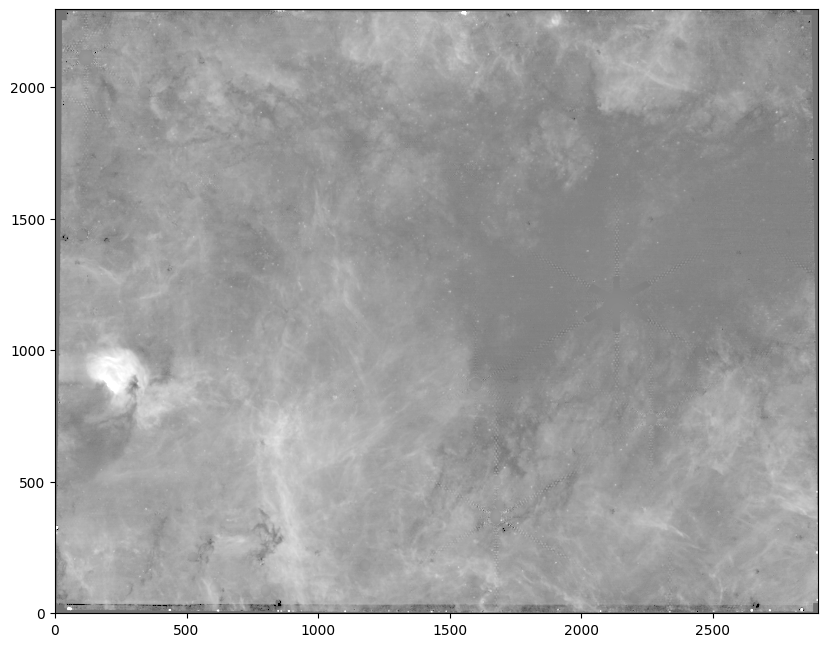

In [44]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

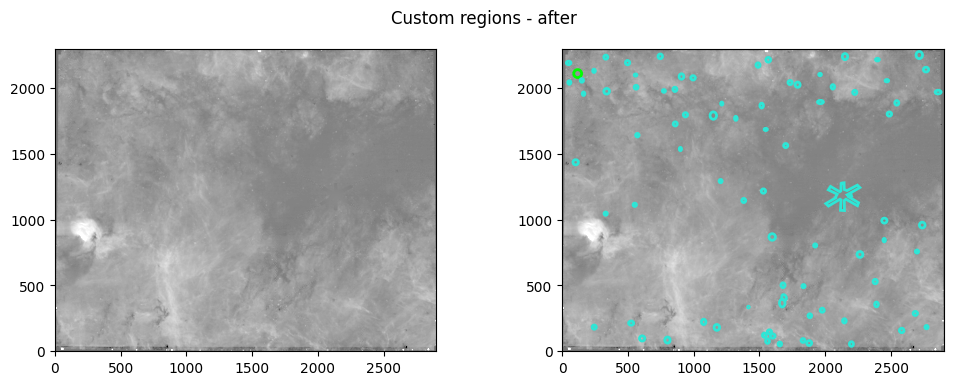

In [45]:
pl.figure(figsize=(12,4))
pl.suptitle("Custom regions - after")
pl.subplot(1,2,1)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
for reg in regs:
    preg = reg.to_pixel(ww)
    preg.plot()

In [46]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred4.fits', overwrite=True)

In [47]:
data = fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred4.fits')

# Destar 5: fainter stars from f410

In [48]:
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
stars_410_f = DAOStarFinder(threshold=25, fwhm=2.302, peakmax=150)(fh_410['SCI'].data)
len(stars_410_f)

13957

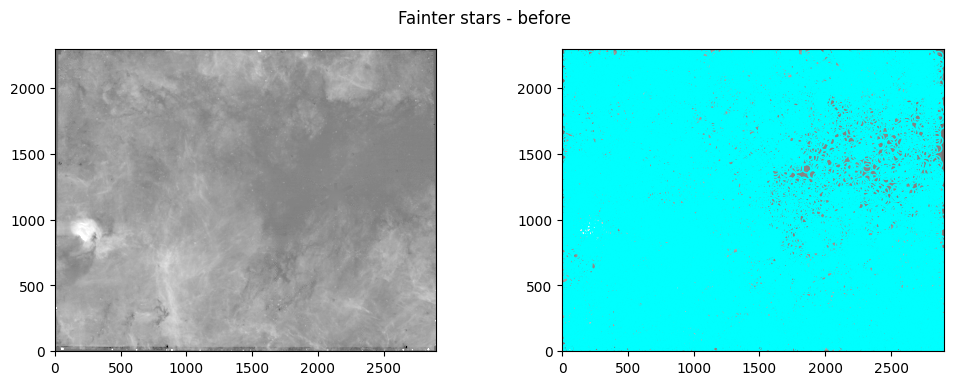

In [49]:
pl.figure(figsize=(12,4))
pl.suptitle("Fainter stars - before")
pl.subplot(1,2,1)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_410_f['xcentroid'], stars_410_f['ycentroid'], edgecolor='cyan', facecolor='none');

In [50]:
for row in tqdm(stars_410_f):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/13957 [00:00<?, ?it/s]

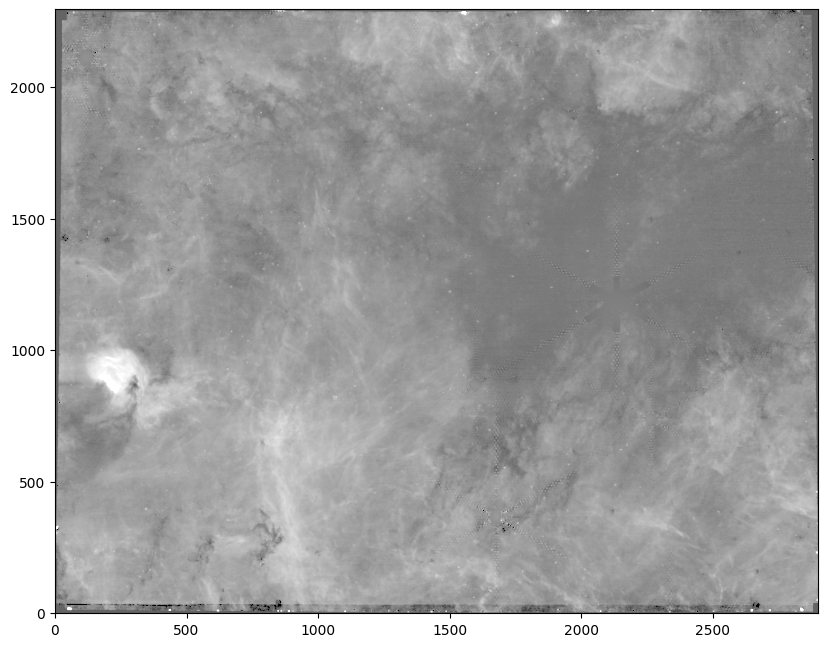

In [51]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

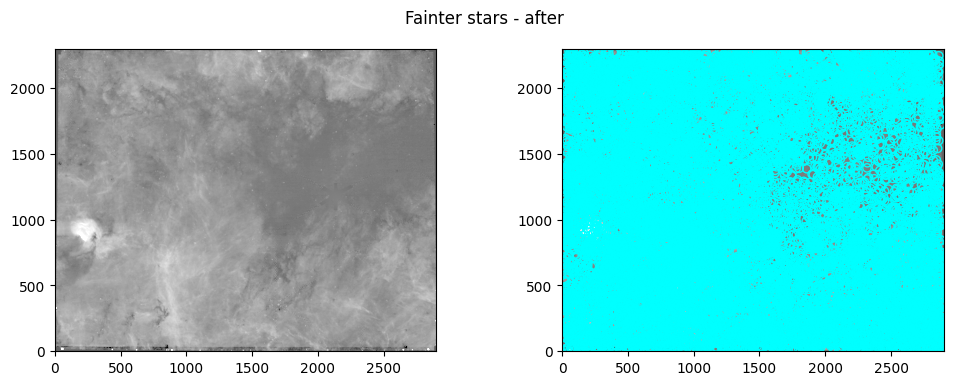

In [52]:
pl.figure(figsize=(12,4))
pl.suptitle("Fainter stars - after")
pl.subplot(1,2,1)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_410_f['xcentroid'], stars_410_f['ycentroid'], edgecolor='cyan', facecolor='none');

In [53]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred5.fits', overwrite=True)

In [54]:
data = fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred5.fits')

# Destar 6: Saturated stars from F410

In [55]:
# Saturated in f410
stars_bra_sat410 = DAOStarFinder(threshold=500, fwhm=2.302, peakmax=3000)(fh_405['SCI'].data)
len(stars_bra_sat410)

2422

In [56]:
for row in tqdm(stars_bra_sat410):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 5.5, 2)

  0%|          | 0/2422 [00:00<?, ?it/s]

In [57]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred6.fits', overwrite=True)

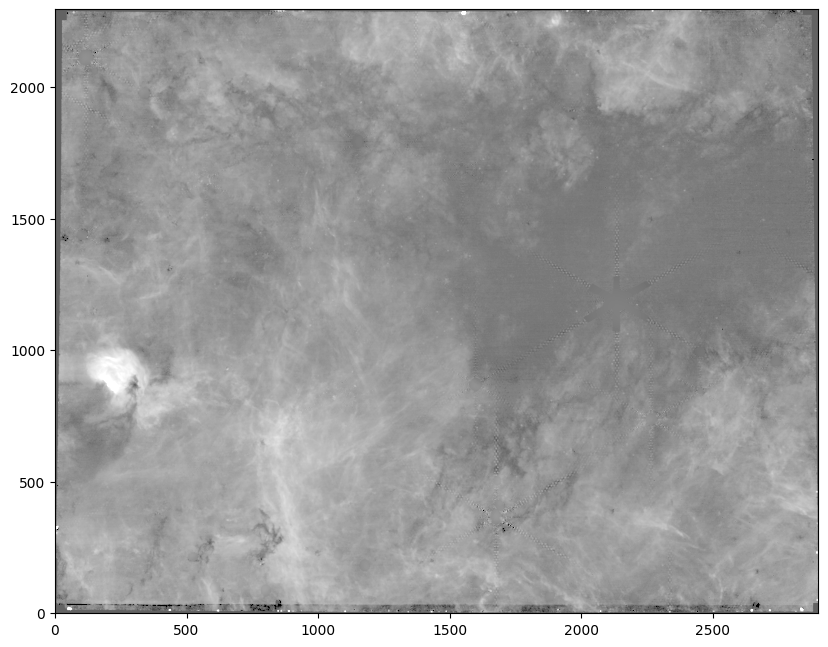

In [58]:
img405sub = fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred6.fits')
pl.imshow(np.nan_to_num(img405sub), norm=simple_norm(img405sub, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray');
#pl.scatter(stars_bra['xcentroid'], stars_bra['ycentroid'], marker='x', color='r')

# Do it again for f466

In [59]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits')
np.isnan(data).sum()

36

In [60]:
print(np.isnan(data).sum())
for sy, sx in tqdm(zip(*np.where(np.isnan(data)))):
    if sx > 5 and sy > 5 and sy < data.shape[0] - 5 and sx < data.shape[1] - 5:
        co = data[sy-5:sy+5, sx-5:sx+5]
        #print(np.isnan(co)).sum()
        data[sy-5:sy+5, sx-5:sx+5] = kill_star(co, 1)
        #print(np.isnan(data[sy-5:sy+5, sx-5:sx+5]).sum())
print(np.isnan(data).sum())
assert not np.isnan(data[1054,645]) #this check is for BrA...

36


0it [00:00, ?it/s]

0


In [61]:
data[data<0] = 0

# Destar 1

In [62]:
stars_466 = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(data)
len(stars_466)

1100

In [63]:
for row in tqdm(stars_bra):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/1928 [00:00<?, ?it/s]

In [64]:
header = fits.getheader(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred.fits', overwrite=True)

# Destar 3

In [65]:
for row in tqdm(stars_410):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 5.5, 1.5)

  0%|          | 0/6540 [00:00<?, ?it/s]

In [66]:
header = fits.getheader(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred2.fits', overwrite=True)

In [67]:
fh_466 = fits.open(f'{basepath}/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits')
stars_466_br = DAOStarFinder(threshold=2000, fwhm=2.302, peakmax=3e4)(fh_466['SCI'].data)
len(stars_466_br)

336

# Destar 3

In [68]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred2.fits')

In [69]:
for row in tqdm(stars_466_br):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 30 and sy > 30 and sy < data.shape[0] - 30 and sx < data.shape[1] - 30:
        #co = data[sy-15:sy+15, sx-15:sx+15]
        #data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 7.5, 2)
        co = data[sy-30:sy+30, sx-30:sx+30]
        data[sy-30:sy+30, sx-30:sx+30] = kill_star(co, 15, 5)

  0%|          | 0/336 [00:00<?, ?it/s]

In [70]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred3.fits', overwrite=True)

# Destar 4

In [71]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred3.fits')

In [72]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(data, 100, npixels=5)

In [73]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segment_map)
cattbl = cat.to_table()

In [74]:
# pixel coordinate of bright extended emission
xk,yk = 208,782

In [75]:
for row in tqdm(cat):
    if row.area.value > 1000: 
        print(f"Skipping {row}, {row.centroid}")
        continue
    if xk < row.bbox.ixmin or xk > row.bbox.ixmax or yk < row.bbox.iymin or yk > row.bbox.ixmax:
        sx,sy = map(int, (row.centroid))
        dx = 20 if row.area.value < 75 else 30
        rad_excise = 10 if row.area.value < 75 else 15
        rad_kernel = 2 if row.area.value < 75 else 4
        if sx > dx and sy > dx and sy < data.shape[0] - dx and sx < data.shape[1] - dx:
            co = data[sy-dx:sy+dx, sx-dx:sx+dx]
            data[sy-dx:sy+dx, sx-dx:sx+dx] = kill_star(co, rad_excise, rad_kernel)
    else:
        print(f"Skipped {row} -> {row.centroid}")

  0%|          | 0/40 [00:00<?, ?it/s]

Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [24], [211.95022602 869.11057116]


In [76]:
import regions
regs = regions.Regions.read(f'{basepath}/regions/manual_destar_left_466.reg')

In [77]:
for reg in tqdm(regs):
    preg = reg.to_pixel(ww)
    mask = preg.to_mask()
    bbox = mask.bbox
    dx = 10
    bbox.ixmin -= dx
    bbox.iymin -= dx
    bbox.ixmax += dx
    bbox.iymax += dx
    co = data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax].copy()
    print(bbox, co.shape, data.shape, mask.data.shape)
    co[dx:-dx, dx:-dx][mask.data.astype('bool')] = np.nan
    msk = np.isnan(co)
    sm = convolve(co, Gaussian2DKernel(10))
    #sm[sm < 0] = 0
    co[msk] = sm[msk]
    data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax] = co

  0%|          | 0/36 [00:00<?, ?it/s]

RegionBoundingBox(ixmin=1965, ixmax=2325, iymin=1002, iymax=1374) (372, 360) (2296, 2901) (352, 340)
RegionBoundingBox(ixmin=2698, ixmax=2773, iymin=923, iymax=1000) (77, 75) (2296, 2901) (57, 55)
RegionBoundingBox(ixmin=2412, ixmax=2487, iymin=801, iymax=883) (82, 75) (2296, 2901) (62, 55)
RegionBoundingBox(ixmin=2216, ixmax=2299, iymin=699, iymax=783) (84, 83) (2296, 2901) (64, 63)
RegionBoundingBox(ixmin=1542, ixmax=1814, iymin=269, iymax=492) (223, 272) (2296, 2901) (203, 252)
RegionBoundingBox(ixmin=1882, ixmax=1964, iymin=759, iymax=844) (85, 82) (2296, 2901) (65, 62)
RegionBoundingBox(ixmin=1554, ixmax=1638, iymin=826, iymax=912) (86, 84) (2296, 2901) (66, 64)
RegionBoundingBox(ixmin=1050, ixmax=1103, iymin=216, iymax=254) (38, 53) (2296, 2901) (18, 33)
RegionBoundingBox(ixmin=466, ixmax=507, iymin=1054, iymax=1095) (41, 41) (2296, 2901) (21, 21)
RegionBoundingBox(ixmin=877, ixmax=940, iymin=1389, iymax=1444) (55, 63) (2296, 2901) (35, 43)
RegionBoundingBox(ixmin=866, ixmax=936,

In [78]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred4.fits', overwrite=True)

# Destar 5

In [79]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred4.fits')

In [ ]:
pl.figure(figsize=(12,4))
pl.suptitle("Fainter stars - before")
pl.subplot(1,2,1)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_410_f['xcentroid'], stars_410_f['ycentroid'], edgecolor='cyan', facecolor='none');

In [80]:
for row in tqdm(stars_410_f):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/13957 [00:00<?, ?it/s]

In [ ]:
pl.figure(figsize=(12,4))
pl.suptitle("Fainter stars - after")
pl.subplot(1,2,1)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2)
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_410_f['xcentroid'], stars_410_f['ycentroid'], edgecolor='cyan', facecolor='none');

In [81]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred5.fits', overwrite=True)

# Destar 6

In [82]:
data = fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred5.fits')

In [83]:
# Saturated in f410
stars_466_sat410 = DAOStarFinder(threshold=500, fwhm=2.302, peakmax=3000)(fh_466['SCI'].data)
len(stars_466_sat410)

872

In [84]:
for row in tqdm(stars_466_sat410):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 5.5, 2)

  0%|          | 0/872 [00:00<?, ?it/s]

In [85]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred6.fits', overwrite=True)

In [86]:
import pyavm
import PIL
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [ ]:
rgb = np.array(
      [
       #fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits'),
       #fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca.fits'),
       fits.getdata(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrca_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F410_minus_F405_nrca.fits')
      ]
).swapaxes(0,2).swapaxes(0,1)
#for layer in (0,1,2):
#    # desaturate stars (though this will whiten the edges!)
#    rgb[:,:,layer][np.isnan(rgb[:,:,layer])] = np.nanmax(rgb[:,:,layer])
#    rgb[:,:,layer][rgb[:,:,layer] == 0] = np.nanmax(rgb[:,:,layer])

In [ ]:
AVM = pyavm.AVM.from_header(fits.getheader(f'{basepath}/images/F410_minus_F405_nrca.fits'))
# AVM = pyavm.AVM.from_header(fits.getheader(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits', ext=['SCI', 1]))

In [ ]:
def save_rgb(img, filename):
    img = (img*256)
    img[img<0] = 0
    img[img>255] = 255
    img = img.astype('uint8')
    img = PIL.Image.fromarray(img[::-1,:,:])
    img.save(filename)

## First RGB product

In [ ]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-2, max_cut=70)(rgb[:,:,0]),
                       simple_norm(narrowsum,  stretch='asinh', min_cut=-4, max_cut=170)(narrowsum),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-2, max_cut=100)(rgb[:,:,1]),
]).swapaxes(0,2).swapaxes(0,1)
#hsv = rgb_to_hsv(rgb_scaled)
#hsv[:,:,0] += -0.35  # 0.25 = 90/360
#hsv[:,:,0] = hsv[:,:,0] % 1 
#rgb_scaled = hsv_to_rgb(hsv)
pl.figure(figsize=(24,10))
pl.imshow(rgb_scaled, origin='lower')
pl.xticks([]);
pl.yticks([]);

outfn = f"{basepath}/images/BrickJWST_nrca_longwave_narrowband_unrotated_lighter.png"
save_rgb(rgb_scaled, outfn)
AVM.embed(outfn, outfn)

In [ ]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-2, max_cut=70)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-2, max_cut=100)(rgb[:,:,1]),
                       simple_norm(narrowsum,  stretch='asinh', min_cut=-4, max_cut=170)(narrowsum)]).swapaxes(0,2).swapaxes(0,1)
hsv = rgb_to_hsv(rgb_scaled)
hsv[:,:,0] += -0.35  # 0.25 = 90/360
hsv[:,:,0] = hsv[:,:,0] % 1 
rgb_scaled = hsv_to_rgb(hsv)
pl.figure(figsize=(24,10))
pl.imshow(rgb_scaled, origin='lower')
pl.xticks([]);
pl.yticks([]);

outfn = f"{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png"
save_rgb(rgb_scaled, outfn)
AVM.embed(outfn, outfn)

In [ ]:
PIL.Image.open(outfn)

In [ ]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-1, max_cut=120)(rgb[:,:,1]),
                       simple_norm(narrowsum,  stretch='asinh', min_cut=-2, max_cut=210)(narrowsum)]).swapaxes(0,2).swapaxes(0,1)
hsv = rgb_to_hsv(rgb_scaled)
hsv[:,:,0] += -0.35  # 0.25 = 90/360
hsv[:,:,0] = hsv[:,:,0] % 1 
rgb_scaled = hsv_to_rgb(hsv)
pl.figure(figsize=(24,10))
pl.imshow(rgb_scaled, origin='lower')
pl.xticks([]);
pl.yticks([]);

outfn = f"{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated.png"
save_rgb(rgb_scaled, outfn)
AVM.embed(outfn, outfn)